# Load dependencies

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Extract the Dataset

In [0]:
import zipfile
dataset_path = "/content/drive/My Drive/MICCAI_BraTS_2019_Data_Training.zip"
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

## Get required packages

## Imports


In [0]:
import sys
sys.path.append('/content/drive/My Drive/VolumMedSeg')

import numpy as np 
from matplotlib import rc
from IPython.display import HTML

from src.utils import *
from src.visualization import *
from src.preprocessing import preprocess_label, prepare

rc('animation', html='jshtml')

In [0]:
preprocessed_dist_path = "/content/drive/My Drive/BTATS2019_preprocessed/3D"
preprocessed2d_dist_path = "/content/drive/My Drive/BTATS2019_preprocessed/2D"
dataset_name = "brats19"

## Loading Data


Parse all the filenames and create a dictionary for each patient with structure:

{<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1': _<path to t1 MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t2': _<path to t2 MRI&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'flair': _<path to FLAIR MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1ce': _<path to t1ce MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'seg': _<path to Ground Truth file&gt;_,<br />
}<br />

In [0]:
hgg = "/content/MICCAI_BraTS_2019_Data_Training/HGG"
lgg = "/content/MICCAI_BraTS_2019_Data_Training/LGG"
data_paths = get_fpaths(hgg)
data_paths.extend(get_fpaths(lgg))

scan_types = ["t1", "t2", "t1ce", "flair", "seg"]

In [6]:
print("Dataset's size is", len(data_paths))

Dataset's size is 335


In [7]:
data_paths

[{'flair': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAG_1/BraTS19_CBICA_AAG_1_flair.nii.gz',
  'seg': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAG_1/BraTS19_CBICA_AAG_1_seg.nii.gz',
  't1': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAG_1/BraTS19_CBICA_AAG_1_t1.nii.gz',
  't1ce': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAG_1/BraTS19_CBICA_AAG_1_t1ce.nii.gz',
  't2': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAG_1/BraTS19_CBICA_AAG_1_t2.nii.gz'},
 {'flair': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAP_1/BraTS19_CBICA_AAP_1_flair.nii.gz',
  'seg': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAP_1/BraTS19_CBICA_AAP_1_seg.nii.gz',
  't1': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAP_1/BraTS19_CBICA_AAP_1_t1.nii.gz',
  't1ce': '/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAP_1/BraTS19_CBICA_AAP_1_t1ce.nii.gz',
  't2': '/content/MIC

# Exploratory data analysis

Each volume have 4 scanning images: FLAIR, T1, T1c and T2.

Each volume have 4 segmentation labels:
*   Label 0: background
*   Label 1: necrotic and non-enhancing tumor
*   Label 2: edema 
*   Label 4: enhancing tumor

In [8]:
img_type_shapes = {t:[] for t in scan_types}

for imgs in tqdm(data_paths):
  for img_type in scan_types:
    img_type_shapes[img_type].append(read_img(imgs[img_type]).shape)

print()
for img_type, shapes in img_type_shapes.items():
  print(f"{img_type} has shapes: {' '.join([str(sh) for sh in set(shapes)])}")

100%|██████████| 335/335 [03:04<00:00,  1.81it/s]


t1 has shapes: (155, 240, 240, 1)
t2 has shapes: (155, 240, 240, 1)
t1ce has shapes: (155, 240, 240, 1)
flair has shapes: (155, 240, 240, 1)
seg has shapes: (155, 240, 240, 1)


## Show a sample

In [0]:
imgs2vis = {m:read_img(data_paths[15][m]) for m in ['t1', 'seg']}

In [0]:
show_images(imgs2vis['t1'][:, :, :, 0], cols=16, scale=2)

In [0]:
show_images(imgs2vis['seg'][:, :, :, 0], cols=16, scale=2)

## Class frequency

In [9]:
class2pixel = {'background': 0,'ncr': 1, 'ed': 2, 'et': 4}
pixel2class = {p:c for c, p in class2pixel.items()}
classes_freq = get_class_frequency(data_paths, class2pixel.values())

100%|██████████| 335/335 [02:14<00:00,  2.50it/s]


In [10]:
classes_freq

{0: 2957762889, 1: 7566423, 2: 19290531, 4: 6260157}

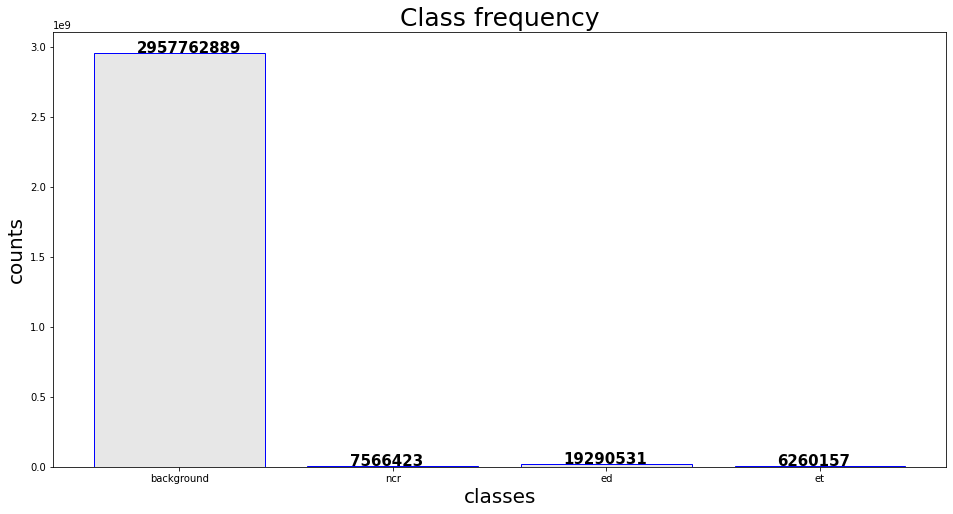

In [11]:
show_class_frequency(classes_freq, class2pixel.keys(), pixel2class)

In [12]:
classes_freq.values()

dict_values([2957762889, 7566423, 19290531, 6260157])

## Preprocesse data



In [0]:
prepare(data_paths, dataset_name, preprocessed_dist_path, mode="3D")

In [0]:
prepare(data_paths, dataset_name, preprocessed2d_dist_path, mode="2D")

100%|██████████| 335/335 [26:50<00:00,  4.81s/it]


In [0]:
preprocessed_data_paths = get_fpaths(preprocessed_dist_path)

### Explore preprocessed data

In [0]:
data = get_preprocessed_data(preprocessed_data_paths, scan_types=scan_types)

100%|██████████| 335/335 [35:19<00:00,  6.33s/it]


In [0]:
final_shape = get_final_shape(data)

100%|██████████| 335/335 [00:00<00:00, 187620.76it/s]


In [0]:
final_shape

(160, 192, 160)

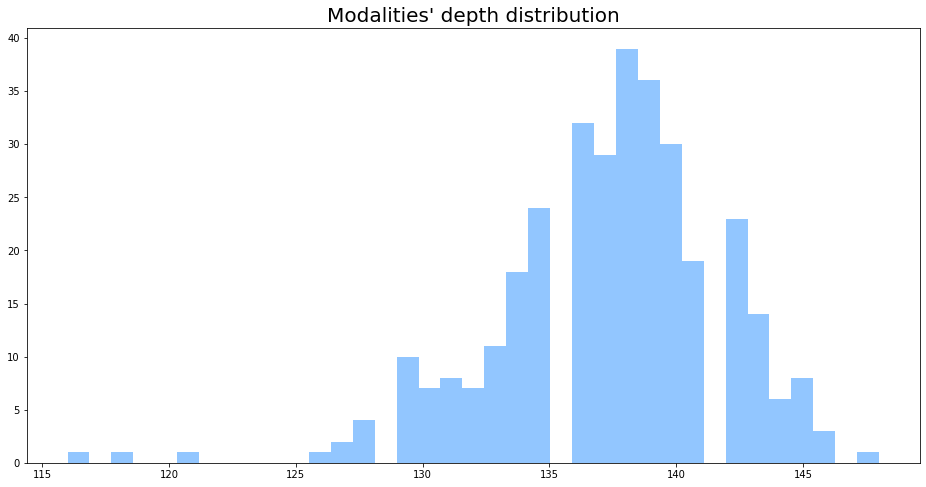

In [0]:
show_depth_hist(data)

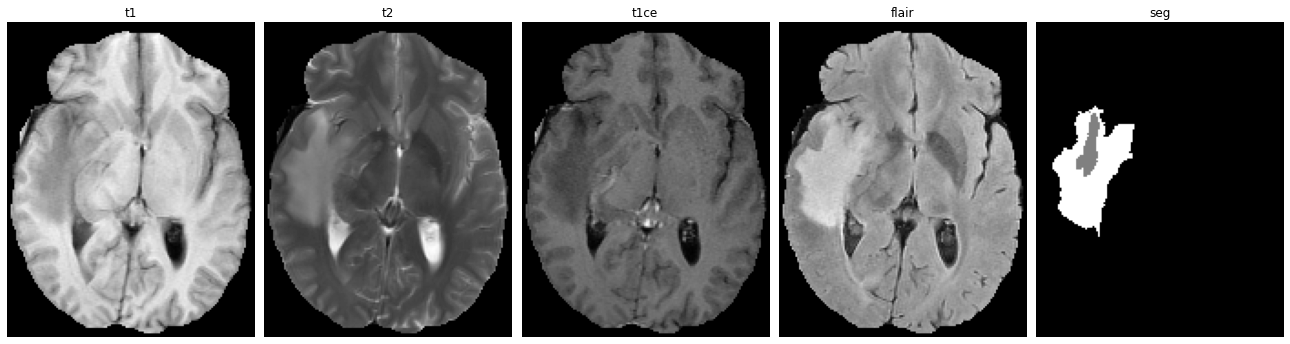

In [0]:
show_modalities(data[180], data[150]['t1'].shape[0] // 2, scan_types)